# Theory

## Day 1: Patch Embedding

In [ ]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        # Conv2d with stride=patch_size acts as patch extractor + linear projection
        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        # x: [batch, channels, height, width]
        x = self.proj(x)  # [B, embed_dim, H/P, W/P]
        x = x.flatten(2)  # [B, embed_dim, N]
        x = x.transpose(1, 2)  # [B, N, embed_dim]
        return x

# Test
patch_embed = PatchEmbedding(img_size=224, patch_size=16, embed_dim=768)
dummy_img = torch.randn(1, 3, 224, 224)
patches = patch_embed(dummy_img)
print("Image shape:", dummy_img.shape)
print("Patch shape:", patches.shape)  # [1, N, 768]

Image shape: torch.Size([1, 3, 224, 224])
Patch shape: torch.Size([1, 196, 768])


## Day 2: Positional Encoding in ViT

In [ ]:
import torch
import torch.nn as nn

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        # +1 for CLS token
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)  # init like ViT

    def forward(self, x):
        # x: [B, N+1, D]
        return x + self.pos_embed

In [ ]:
import math

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        pe = torch.zeros(num_patches + 1, embed_dim)  # +1 for CLS
        position = torch.arange(0, num_patches + 1, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, N+1, D]
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe

In [ ]:
# From Day 1
patch_embed = PatchEmbedding(img_size=224, patch_size=16, embed_dim=768)
num_patches = patch_embed.num_patches

# Add CLS token
cls_token = nn.Parameter(torch.zeros(1, 1, 768))
nn.init.trunc_normal_(cls_token, std=0.02)

# Choose positional encoding type
pos_encoding_learnable = LearnablePositionalEncoding(num_patches, 768)
pos_encoding_fixed = SinusoidalPositionalEncoding(num_patches, 768)

# Dummy image
img = torch.randn(1, 3, 224, 224)
patches = patch_embed(img)  # [1, N, 768]

# Prepend CLS token
cls_tokens = cls_token.expand(patches.size(0), -1, -1)  # [B, 1, D]
tokens = torch.cat((cls_tokens, patches), dim=1)  # [B, N+1, D]

# Add positional encoding
tokens_with_pos = pos_encoding_learnable(tokens)
print("LearnablePositionalEncoding",tokens_with_pos.shape)  # [1, N+1, 768]


tokens_with_pos = pos_encoding_fixed(tokens)
print("SinusoidalPositionalEncoding", tokens_with_pos.shape)  # [1, N+1, 768]

LearnablePositionalEncoding torch.Size([1, 197, 768])
SinusoidalPositionalEncoding torch.Size([1, 197, 768])


##  Day 3: Multi-Head Self-Attention (MHSA) in ViT

In [ ]:
import torch
import torch.nn as nn

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Linear layers for Q, K, V
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)

        # Output projection
        self.proj = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape

        # Compute Q, K, V
        qkv = self.qkv(x)  # [B, N, 3*D]
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, B, num_heads, N, head_dim]
        Q, K, V = qkv[0], qkv[1], qkv[2]

        # Scaled dot-product attention
        attn_scores = (Q @ K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # [B, heads, N, N]
        attn_weights = attn_scores.softmax(dim=-1)
        attn_weights = self.dropout(attn_weights)

        out = attn_weights @ V  # [B, heads, N, head_dim]

        # Concatenate heads
        out = out.transpose(1, 2).reshape(B, N, D)  # [B, N, D]

        # Final projection
        out = self.proj(out)
        return out

In [ ]:
# Assume we have tokens from Day 2
patch_embed = PatchEmbedding(img_size=224, patch_size=16, embed_dim=768)
num_patches = patch_embed.num_patches

cls_token = nn.Parameter(torch.zeros(1, 1, 768))
nn.init.trunc_normal_(cls_token, std=0.02)

pos_encoding = LearnablePositionalEncoding(num_patches, 768)

img = torch.randn(1, 3, 224, 224)
patches = patch_embed(img)
cls_tokens = cls_token.expand(patches.size(0), -1, -1)
tokens = torch.cat((cls_tokens, patches), dim=1)
tokens = pos_encoding(tokens)

# Apply MHSA
mhsa = MultiHeadSelfAttention(embed_dim=768, num_heads=8)
out = mhsa(tokens)
print(out.shape)  # [1, N+1, 768]

torch.Size([1, 197, 768])


## Day 4: Feed-Forward Network (FFN) in ViT

In [ ]:
import torch
import torch.nn as nn

class FeedForwardNetwork(nn.Module):
    def __init__(self, embed_dim=768, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)       # [B, N, hidden_dim]
        x = self.act(x)       # GELU activation
        x = self.dropout(x)
        x = self.fc2(x)       # [B, N, embed_dim]
        x = self.dropout(x)
        return x

In [ ]:
# Dummy tokens from previous steps
tokens = torch.randn(1, 197, 768)  # [B, N+1, D]

ffn = FeedForwardNetwork(embed_dim=768, mlp_ratio=4.0, dropout=0.1)
out = ffn(tokens)
print(out.shape)  # [1, 197, 768]

torch.Size([1, 197, 768])


## Day 5: The Transformer Encoder Block

In [ ]:
import torch
import torch.nn as nn

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.dropout1 = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = FeedForwardNetwork(embed_dim, mlp_ratio, dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        # Pre-Norm + MHSA + Residual
        x = x + self.dropout1(self.attn(self.norm1(x)))
        # Pre-Norm + FFN + Residual
        x = x + self.dropout2(self.ffn(self.norm2(x)))
        return x

In [ ]:
# Dummy tokens: batch=1, sequence length=197 (196 patches + CLS), embed_dim=768
tokens = torch.randn(1, 197, 768)

encoder_block = TransformerEncoderBlock(embed_dim=768, num_heads=8, mlp_ratio=4.0, dropout=0.1)
out = encoder_block(tokens)
print(out.shape)  # [1, 197, 768]

torch.Size([1, 197, 768])


## Day 6: The Classification Head

In [ ]:
import torch
import torch.nn as nn

class ClassificationHead(nn.Module):
    def __init__(self, embed_dim=768, num_classes=1000):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x: [B, N+1, D] → CLS token is at index 0
        cls_token = x[:, 0]  # [B, D]
        cls_token = self.norm(cls_token)
        logits = self.fc(cls_token)  # [B, num_classes]
        return logits

In [ ]:
# Dummy output from last Transformer block
tokens = torch.randn(1, 197, 768)  # [B, N+1, D]

head = ClassificationHead(embed_dim=768, num_classes=10)
logits = head(tokens)
print(logits.shape)  # [1, 10]

torch.Size([1, 10])


## Day 7: Assembling the Full Vision Transformer (ViT)

In [ ]:
import torch
import torch.nn as nn

# --- From previous days ---
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # [B, D, H/P, W/P]
        x = x.flatten(2)  # [B, D, N]
        x = x.transpose(1, 2)  # [B, N, D]
        return x

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        return x + self.pos_embed

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        Q, K, V = qkv[0], qkv[1], qkv[2]
        attn = (Q @ K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        out = (attn @ V).transpose(1, 2).reshape(B, N, D)
        return self.proj(out)

class FeedForwardNetwork(nn.Module):
    def __init__(self, embed_dim=768, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(self.act(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ffn = FeedForwardNetwork(embed_dim, mlp_ratio, dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout1(self.attn(self.norm1(x)))
        x = x + self.dropout2(self.ffn(self.norm2(x)))
        return x

class ClassificationHead(nn.Module):
    def __init__(self, embed_dim=768, num_classes=1000):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        cls_token = x[:, 0]
        return self.fc(self.norm(cls_token))

# --- Full ViT ---
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 num_classes=1000, embed_dim=768, depth=12,
                 num_heads=8, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        self.pos_encoding = LearnablePositionalEncoding(num_patches, embed_dim)

        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        self.head = ClassificationHead(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.pos_encoding(x)
        for blk in self.blocks:
            x = blk(x)
        return self.head(x)

In [ ]:
model = VisionTransformer(img_size=224, patch_size=16, num_classes=10, depth=4, embed_dim=256, num_heads=4)
dummy_img = torch.randn(2, 3, 224, 224)
logits = model(dummy_img)
print(logits.shape)  # [2, 10]

# Practical

## Day 1: The Vision Transformer

In [ ]:
!pip install -U timm torch Pillow requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found ex

In [ ]:
import torch
import timm
from PIL import Image
import requests
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

# 1. Load a pre-trained ViT model from timm
# 'vit_base_patch16_224' is a standard ViT model.
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval() # Set the model to evaluation mode

# 2. Get the model's specific preprocessing steps
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

# 3. Load and preprocess a sample image from a URL
url = 'http://images.cocodataset.org/val2017/000000039769.jpg' # A photo of cats
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

# The transform resizes, crops, and normalizes the image.
# `unsqueeze(0)` adds a batch dimension.
tensor = transform(image).unsqueeze(0)

# 4. Get the features
# We'll pass the image through the model, but stop before the final classification layer.
with torch.no_grad():
    features = model.forward_features(tensor)

# --- Analyze the Output ---
print(f"--- Vision Transformer (ViT) ---")
print(f"Original image shape: {image.size}")
print(f"Input tensor shape after preprocessing: {tensor.shape}")
print(f"Output features shape: {features.shape}")

# The output shape is (batch_size, num_patches + 1, embedding_dim)
# The "+ 1" is for a special [CLS] token used for classification.
num_patches = features.shape[1] - 1
embedding_dim = features.shape[2]
print(f"\nThe image was broken down into {num_patches} patches.")
print(f"Each patch is represented by a vector of size {embedding_dim}.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

--- Vision Transformer (ViT) ---
Original image shape: (640, 480)
Input tensor shape after preprocessing: torch.Size([1, 3, 224, 224])
Output features shape: torch.Size([1, 197, 768])

The image was broken down into 196 patches.
Each patch is represented by a vector of size 768.


## Day 2: Contrastive Learning (CLIP)


In [ ]:
!pip install -U open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.3 MB/s eta 0:00:00


In [ ]:
import torch
import open_clip
from PIL import Image
import requests

# 1. Load the pre-trained CLIP model and its preprocessing function
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')
model.eval()

# 2. Get the tokenizer for the text part of the model
tokenizer = open_clip.get_tokenizer('ViT-B-32-quickgelu')

# 3. Load and preprocess an image
url = 'http://images.cocodataset.org/val2017/000000039769.jpg' # Photo of cats
image = Image.open(requests.get(url, stream=True).raw)
image_input = preprocess(image).unsqueeze(0) # Add batch dimension

# 4. Create and tokenize text descriptions
text_descriptions = [
    "a photo of a dog",
    "a photo of two cats on a couch",
    "a drawing of a car",
    "a remote control and a phone"
]
text_inputs = tokenizer(text_descriptions)

# 5. Generate embeddings for the image and text
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

    # Normalize the features for accurate similarity calculation
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# 6. Calculate the similarity (dot product) between the image and each text description
similarity_scores = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# --- Analyze the Output ---
print(f"--- CLIP Zero-Shot Classification ---")
print("\nSimilarity scores between the image and each description:")

# Print the results
for i, desc in enumerate(text_descriptions):
    print(f"  - '{desc}': {similarity_scores[0][i]:.4f}")

best_match_index = similarity_scores.argmax()
print(f"\nBest match: '{text_descriptions[best_match_index]}'")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

--- CLIP Zero-Shot Classification ---

Similarity scores between the image and each description:
  - 'a photo of a dog': 0.0000
  - 'a photo of two cats on a couch': 1.0000
  - 'a drawing of a car': 0.0000
  - 'a remote control and a phone': 0.0000

Best match: 'a photo of two cats on a couch'


## Day 3: VQA and the BLIP Architecture

In [ ]:
!pip install -U transformers torch Pillow requests timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 631.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from PIL import Image
import requests
from transformers import BlipProcessor, BlipForQuestionAnswering

# 1. Load the pre-trained BLIP model and processor
model_name = "Salesforce/blip-vqa-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForQuestionAnswering.from_pretrained(model_name)
model.eval()

# 2. Load and prepare an image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"  # Photo of cats
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

# 3. Define a question
question = "How many cats are in the picture?"

# 4. Process the image and text together
inputs = processor(image, question, return_tensors="pt")

# 5. Generate an answer
with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=10)

# 6. Decode the generated token IDs back to text
answer = processor.decode(outputs[0], skip_special_tokens=True)

# --- Analyze the Output ---
print(f"--- BLIP Visual Question Answering ---")
print(f"Question: {question}")
print(f"Answer: {answer}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

--- BLIP Visual Question Answering ---
Question: How many cats are in the picture?
Answer: 2


## Day 4: VLM Foundations Review


In [ ]:
import torch
from PIL import Image
import requests
from transformers import ViTFeatureExtractor, ViTModel
from transformers import CLIPProcessor, CLIPModel
from transformers import BlipProcessor, BlipForQuestionAnswering

# --- Setup: Load a sample image ---
url = 'http://images.cocodataset.org/val2017/000000039769.jpg' # Photo of cats
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
print("Sample image loaded.")

# ==============================================================================
# Task 1: Get Image Features with Vision Transformer (ViT)
# ==============================================================================
print("\n--- Running Task 1: ViT Feature Extraction ---")
# Load ViT feature extractor and model
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# Preprocess the image and get features
inputs = vit_feature_extractor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = vit_model(**inputs)
last_hidden_states = outputs.last_hidden_state

print(f"ViT Output Feature Shape: {last_hidden_states.shape}")
print("Task 1 Complete.")


# ==============================================================================
# Task 2: Zero-Shot Classification with CLIP
# ==============================================================================
print("\n--- Running Task 2: CLIP Zero-Shot Classification ---")
# Load CLIP processor and model
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Define text labels
text_labels = ["a photo of a car", "a photo of two cats", "a photo of a dog"]

# Process image and text
inputs = clip_processor(text=text_labels, images=image, return_tensors="pt", padding=True)

# Get similarity scores
with torch.no_grad():
    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)

print(f"CLIP Similarity Probabilities: {probs.tolist()[0]}")
best_match_index = probs.argmax().item()
print(f"Best match: '{text_labels[best_match_index]}'")
print("Task 2 Complete.")


# ==============================================================================
# Task 3: Visual Question Answering with BLIP
# ==============================================================================
print("\n--- Running Task 3: BLIP Visual Question Answering ---")
# Load BLIP processor and model
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
blip_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# Define question
question = "What color is the couch?"

# Process image and question
inputs = blip_processor(image, text=question, return_tensors="pt")

# Generate an answer
with torch.no_grad():
    out = blip_model.generate(**inputs, max_new_tokens=10)

answer = blip_processor.decode(out[0], skip_special_tokens=True)
print(f"Question: {question}")
print(f"BLIP's Answer: {answer}")
print("Task 3 Complete.")

Sample image loaded.

--- Running Task 1: ViT Feature Extraction ---


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViT Output Feature Shape: torch.Size([1, 197, 768])
Task 1 Complete.

--- Running Task 2: CLIP Zero-Shot Classification ---


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP Similarity Probabilities: [6.76041454426013e-05, 0.9997784495353699, 0.0001540015946375206]
Best match: 'a photo of two cats'
Task 2 Complete.

--- Running Task 3: BLIP Visual Question Answering ---
Question: What color is the couch?
BLIP's Answer: pink
Task 3 Complete.


## Day 5: The Flamingo Architecture - High-Level Overview

## Day 6: Gated Cross-Attention

In [ ]:
import torch
import torch.nn as nn

# We can reuse our SelfAttention module from the first project!
# It already has the logic to handle separate Q, K, and V inputs.
class CrossAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(CrossAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size, bias=False)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values, keys, queries = self.values(values).permute(0, 2, 1, 3), self.keys(keys).permute(0, 2, 1, 3), self.queries(queries).permute(0, 2, 1, 3)

        energy = torch.matmul(queries, keys.transpose(-2, -1))
        if mask is not None: energy = energy.masked_fill(mask == 0, float("-1e20"))
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=-1)
        out = torch.matmul(attention, values)
        out = out.permute(0, 2, 1, 3).contiguous()
        out = out.reshape(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)
        return out


In [ ]:

class GatedCrossAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(GatedCrossAttention, self).__init__()
        self.attention = CrossAttention(embed_size, heads)

        # The gating parameter, initialized to 0
        self.gate = nn.Parameter(torch.tensor([0.0]))

    def forward(self, text_embedding, image_features):
        # text_embedding is the Query
        # image_features are the Keys and Values

        # Get the visual information
        attended_visuals = self.attention(
            values=image_features,
            keys=image_features,
            query=text_embedding,
            mask=None
        )

        # Apply the gate: alpha * attended_visuals
        # We use tanh to keep the gate's influence bounded (-1 to 1)
        gated_visuals = torch.tanh(self.gate) * attended_visuals

        # Return the original text embedding plus the gated visual information
        return text_embedding + gated_visuals


In [ ]:
# --- Let's test it ---
embed_size = 768  # e.g., hidden size of the LLM
heads = 8
batch_size = 4
text_seq_len = 50
image_num_patches = 197

# Dummy text embeddings from an LLM layer
text_input = torch.rand(batch_size, text_seq_len, embed_size)
# Dummy image features from a Vision Encoder
image_input = torch.rand(batch_size, image_num_patches, embed_size)

# Create and apply the GatedCrossAttention layer
gated_cross_attn_layer = GatedCrossAttention(embed_size, heads)
output = gated_cross_attn_layer(text_input, image_input)

print("--- Gated Cross-Attention ---")
print(f"Text input shape: {text_input.shape}")
print(f"Image input shape: {image_input.shape}")
print(f"Output shape: {output.shape}")
print("\nSuccess! The output shape is the same as the text input shape,")
print("meaning it can replace a standard self-attention block in an LLM.")

--- Gated Cross-Attention ---
Text input shape: torch.Size([4, 50, 768])
Image input shape: torch.Size([4, 197, 768])
Output shape: torch.Size([4, 50, 768])

Success! The output shape is the same as the text input shape,
meaning it can replace a standard self-attention block in an LLM.


## Day 7: Modifying a Pre-Trained LLM

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoConfig

# --- Paste your GatedCrossAttention and CrossAttention classes from Day 6 here ---
class CrossAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(CrossAttention, self).__init__()
        self.embed_size = embed_size; self.heads = heads; self.head_dim = embed_size // heads
        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size, bias=False)
    def forward(self, values, keys, query, mask):
        N = query.shape[0]; value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
        values = values.reshape(N, value_len, self.heads, self.head_dim); keys = keys.reshape(N, key_len, self.heads, self.head_dim); queries = query.reshape(N, query_len, self.heads, self.head_dim)
        values = self.values(values); keys = self.keys(keys); queries = self.queries(queries)
        queries = queries.permute(0, 2, 1, 3); keys = keys.permute(0, 2, 1, 3); values = values.permute(0, 2, 1, 3)
        energy = torch.matmul(queries, keys.transpose(-2, -1))
        if mask is not None: energy = energy.masked_fill(mask == 0, float("-1e20"))
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=-1)
        out = torch.matmul(attention, values)
        out = out.permute(0, 2, 1, 3).contiguous()
        out = out.reshape(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)
        return out

class GatedCrossAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(GatedCrossAttention, self).__init__()
        self.attention = CrossAttention(embed_size, heads)
        self.gate = nn.Parameter(torch.tensor([0.0]))
    def forward(self, text_embedding, image_features):
        attended_visuals = self.attention(values=image_features, keys=image_features, query=text_embedding, mask=None)
        gated_visuals = torch.tanh(self.gate) * attended_visuals
        return text_embedding + gated_visuals


# --- Main Task: Modify the LLM ---

# 1. Load a pre-trained LLM and its configuration
model_name = "facebook/opt-125m"
config = AutoConfig.from_pretrained(model_name)
llm = AutoModelForCausalLM.from_pretrained(model_name)

# Extract model dimensions from the config
embed_size = config.hidden_size
heads = config.num_attention_heads

print(f"--- Modifying LLM: {model_name} ---")
print(f"Original model's self_attn layer: {llm.model.decoder.layers[0].self_attn.__class__.__name__}")

# 2. Iterate through the LLM's layers and replace the self-attention module
for i, layer in enumerate(llm.model.decoder.layers):
    print(f"Replacing self-attention in layer {i}...")
    # Replace the original self_attn module with our custom one
    layer.self_attn = GatedCrossAttention(embed_size, heads)

print("\n--- Model Modification Complete ---")
print(f"New model's self_attn layer: {llm.model.decoder.layers[0].self_attn.__class__.__name__}")

# We now need to adjust the forward pass of the decoder layer to accept image features.
# For today, we will just prove that we can replace the layers.
# The full forward pass modification will come next.
print("\nNext steps: Modify the decoder layer's forward pass to accept and use image_features.")

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

--- Modifying LLM: facebook/opt-125m ---
Original model's self_attn layer: OPTAttention
Replacing self-attention in layer 0...
Replacing self-attention in layer 1...
Replacing self-attention in layer 2...
Replacing self-attention in layer 3...
Replacing self-attention in layer 4...
Replacing self-attention in layer 5...
Replacing self-attention in layer 6...
Replacing self-attention in layer 7...
Replacing self-attention in layer 8...
Replacing self-attention in layer 9...
Replacing self-attention in layer 10...
Replacing self-attention in layer 11...

--- Model Modification Complete ---
New model's self_attn layer: GatedCrossAttention

Next steps: Modify the decoder layer's forward pass to accept and use image_features.


## Day 8: Assembling the "Mini-Flamingo"


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
from timm import create_model

from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, resize

# --- Paste your GatedCrossAttention and CrossAttention classes here ---
class CrossAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(CrossAttention, self).__init__()
        self.embed_size = embed_size; self.heads = heads; self.head_dim = embed_size // heads
        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size, bias=False)
    def forward(self, values, keys, query, mask):
        N = query.shape[0]; value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
        values = values.reshape(N, value_len, self.heads, self.head_dim); keys = keys.reshape(N, key_len, self.heads, self.head_dim); queries = query.reshape(N, query_len, self.heads, self.head_dim)
        values = self.values(values); keys = self.keys(keys); queries = self.queries(queries)
        queries = queries.permute(0, 2, 1, 3); keys = keys.permute(0, 2, 1, 3); values = values.permute(0, 2, 1, 3)
        energy = torch.matmul(queries, keys.transpose(-2, -1))
        if mask is not None: energy = energy.masked_fill(mask == 0, float("-1e20"))
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=-1)
        out = torch.matmul(attention, values)
        out = out.permute(0, 2, 1, 3).contiguous()
        out = out.reshape(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)
        return out

class GatedCrossAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(GatedCrossAttention, self).__init__()
        self.attention = CrossAttention(embed_size, heads)
        self.gate = nn.Parameter(torch.tensor([0.0]))

    # def forward(self, text_embedding, image_features):
    #     attended_visuals = self.attention(values=image_features, keys=image_features, query=text_embedding, mask=None)
    #     gated_visuals = torch.tanh(self.gate) * attended_visuals
    #     return text_embedding + gated_visuals

    def forward(self, hidden_states, image_features, **kwargs):
        # The 'query' for cross-attention is the text's hidden_states
        attended_visuals = self.attention(
            values=image_features,
            keys=image_features,
            query=hidden_states,
            mask=None  # We don't need a mask for the visual features
        )
        gated_visuals = torch.tanh(self.gate) * attended_visuals
        # Return the original text embedding plus the gated visual information
        return hidden_states + gated_visuals


# --- The Final, Fully Working MiniFlamingo Class ---
class MiniFlamingo(nn.Module):
    def __init__(self, vision_encoder_name, llm_name):
        super().__init__()
        self.vision_encoder = create_model(vision_encoder_name, pretrained=True, num_classes=0) # No classifier
        self.vision_encoder.eval()
        for param in self.vision_encoder.parameters():
            param.requires_grad = False

        self.llm = AutoModelForCausalLM.from_pretrained(llm_name)
        config = self.llm.config

        for name, param in self.llm.named_parameters():
            param.requires_grad = False

        for i, layer in enumerate(self.llm.model.decoder.layers):
            layer.self_attn = GatedCrossAttention(config.hidden_size, config.num_attention_heads)
            for name, param in layer.self_attn.named_parameters():
                if 'gate' in name:
                    param.requires_grad = True

    def forward(self, image_tensor, text_tokens):
      with torch.no_grad():
          # Get patch embeddings instead of pooled vector
          image_features = self.vision_encoder.forward_features(image_tensor)  # [B, num_patches, embed_dim]

      batch_size, seq_length = text_tokens.shape
      position_ids = torch.arange(0, seq_length, dtype=torch.long, device=text_tokens.device).unsqueeze(0).repeat(batch_size, 1)

      word_embeddings = self.llm.model.decoder.embed_tokens(text_tokens)
      positional_embeddings = self.llm.model.decoder.embed_positions(position_ids)
      hidden_states = word_embeddings + positional_embeddings

      for decoder_layer in self.llm.model.decoder.layers:
          residual = hidden_states
          hidden_states = decoder_layer.self_attn_layer_norm(hidden_states)
          hidden_states = decoder_layer.self_attn(hidden_states=hidden_states, image_features=image_features)
          hidden_states = residual + hidden_states

          residual = hidden_states
          hidden_states = decoder_layer.final_layer_norm(hidden_states)
          hidden_states = decoder_layer.fc1(hidden_states)
          hidden_states = decoder_layer.activation_fn(hidden_states)
          hidden_states = decoder_layer.fc2(hidden_states)
          hidden_states = residual + hidden_states

      logits = self.llm.lm_head(hidden_states)
      return logits

# --- Let's test the full implementation ---
mini_flamingo = MiniFlamingo('vit_base_patch16_224', 'facebook/opt-125m')

# A helper function to print trainable parameters
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.4f}"
    )

print_trainable_parameters(mini_flamingo)

# --- Simulate a forward pass ---
model = mini_flamingo.vision_encoder
config = resolve_data_config({}, model=model)
transform = create_transform(**config)
url = 'http://images.cocodataset.org/val2017/000000039769.jpg' # A photo of cats
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
dummy_image = transform(image).unsqueeze(0)

tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')
dummy_text = tokenizer("A picture of ", return_tensors="pt").input_ids

# Generate one token
with torch.no_grad():
    output_logits = mini_flamingo(dummy_image, dummy_text)
    next_token_id = torch.argmax(output_logits[0, -1, :])
    next_token = tokenizer.decode(next_token_id)

print("\n--- Full Forward Pass Complete ---")
print(f"Input text: 'A picture of '")
print(f"Model generated next token: '{next_token}'")

trainable params: 7225356 || all params: 189914892 || trainable%: 3.8045

--- Full Forward Pass Complete ---
Input text: 'A picture of '
Model generated next token: ' '


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from timm import create_model


class CrossAttention(nn.Module):
    """
    Multi-head attention implemented manually but with correct scaling and shapes.
    Accepts:
      - values: (B, value_len, D)
      - keys:   (B, key_len, D)
      - query:  (B, query_len, D)
      - mask:   (B, 1, query_len, key_len) OR (B, 1, 1, key_len) or None
    Returns:
      - out: (B, query_len, D)
    """
    def __init__(self, embed_size, heads):
        super().__init__()
        assert embed_size % heads == 0, "embed_size must be divisible by heads"
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        # project from full embed_size -> full embed_size then split heads
        self.to_q = nn.Linear(embed_size, embed_size, bias=False)
        self.to_k = nn.Linear(embed_size, embed_size, bias=False)
        self.to_v = nn.Linear(embed_size, embed_size, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size, bias=False)

    def forward(self, values, keys, query, mask=None):
        B, value_len, _ = values.shape
        _, key_len, _ = keys.shape
        _, query_len, _ = query.shape

        # linear projections
        Q = self.to_q(query)   # (B, query_len, D)
        K = self.to_k(keys)    # (B, key_len, D)
        V = self.to_v(values)  # (B, value_len, D)

        # reshape for heads -> (B, heads, seq_len, head_dim)
        Q = Q.view(B, query_len, self.heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(B, key_len, self.heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(B, value_len, self.heads, self.head_dim).permute(0, 2, 1, 3)

        # attention scores: (B, heads, query_len, key_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)

        if mask is not None:
            # mask expected broadcastable to (B, 1, query_len, key_len)
            scores = scores.masked_fill(mask == 0, float("-1e20"))

        attn = torch.softmax(scores, dim=-1)  # (B, heads, query_len, key_len)

        out = torch.matmul(attn, V)  # (B, heads, query_len, head_dim)
        out = out.permute(0, 2, 1, 3).contiguous().view(B, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)  # (B, query_len, D)
        return out


class GatedCrossAttention(nn.Module):
    """
    Wraps CrossAttention and applies a learnable scalar gate (tanh) to the attended visual features.
    Only the gate parameter will be trainable by default.
    forward signature: (hidden_states, image_features, attention_mask=None)
    returns: hidden_states + gated_attended_visuals
    """
    def __init__(self, embed_size, heads):
        super().__init__()
        self.attn = CrossAttention(embed_size, heads)
        # scalar gate; initialize near 0 so early behaviour is near identity
        self.gate = nn.Parameter(torch.tensor(0.0))

    def forward(self, hidden_states, image_features, attention_mask=None):
        """
        hidden_states: (B, seq_len, D)
        image_features: (B, num_patches, D)
        attention_mask: optional mask for visual attention (not typically used)
        """
        attended_visuals = self.attn(values=image_features, keys=image_features, query=hidden_states, mask=attention_mask)
        gated = torch.tanh(self.gate) * attended_visuals
        return hidden_states + gated


class MiniFlamingo(nn.Module):
    """
    MiniFlamingo-like wrapper:
    - ViT vision encoder (from timm) -> gives patch embeddings (B, num_patches, vit_dim)
    - small projection to LLM hidden size if needed
    - we keep the LLM frozen and add a per-layer GatedCrossAttention module (frozen except gate)
    - manual forward loop that uses layer norms and feedforward blocks from OPT but
      uses our custom self-attention (causal) and gated cross-attn.
    Note: This manual forward is for forward-pass evaluation / simple training of gates.
    """
    def __init__(self, vision_encoder_name, llm_name, device='cpu'):
        super().__init__()
        self.device = device

        # Vision encoder (timm). num_classes=0 gives features only for some timm models.
        self.vision_encoder = create_model(vision_encoder_name, pretrained=True, num_classes=0)
        self.vision_encoder.eval()
        for p in self.vision_encoder.parameters():
            p.requires_grad = False

        # LLM (frozen)
        self.llm = AutoModelForCausalLM.from_pretrained(llm_name)
        self.llm.eval()
        for _, p in self.llm.named_parameters():
            p.requires_grad = False

        # dims
        llm_dim = self.llm.config.hidden_size

        # get a sample vit embed dim by doing a forward_features call with a dummy (if available)
        # We'll infer vit_dim from the model's first conv/proj if possible
        # Fallback: try to inspect the vision encoder attribute names
        # Simpler: we call forward_features on a dummy to get dimension (cheap here)
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            vit_out = self.vision_encoder.forward_features(dummy)  # e.g., (1, num_patches, vit_dim)
            self.vit_dim = vit_out.shape[-1]

        # projection from vit_dim -> llm_dim if mismatch
        if self.vit_dim != llm_dim:
            self.image_proj = nn.Linear(self.vit_dim, llm_dim)
        else:
            self.image_proj = nn.Identity()

        # create per-layer custom attention modules (self + gated cross-attn)
        self.layers = []
        for i, layer in enumerate(self.llm.model.decoder.layers):
            # attach custom modules onto the hf layer object for easy use
            # custom self-attention (causal) and gated cross-attn
            layer._custom_self_attn = CrossAttention(llm_dim, self.llm.config.num_attention_heads)
            layer._cross_attn = GatedCrossAttention(llm_dim, self.llm.config.num_attention_heads)

            # ensure only gates require grad
            for name, p in layer._cross_attn.named_parameters():
                if 'gate' in name:
                    p.requires_grad = True
                else:
                    p.requires_grad = False

            # custom self-attn default parameters are frozen (we don't train them here)
            for _, p in layer._custom_self_attn.named_parameters():
                p.requires_grad = False

            # store layer reference
            self.layers.append(layer)

    def _build_causal_mask(self, seq_len, device):
        # returns mask shaped (1, 1, seq_len, seq_len) broadcastable to (B, heads, seq_len, seq_len)
        mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool, device=device))
        return mask.unsqueeze(0).unsqueeze(0)

    def forward(self, image_tensor, text_tokens):
        """
        image_tensor: (B, 3, H, W) float
        text_tokens: (B, seq_len) int
        returns logits: (B, seq_len, vocab_size)
        """
        device = image_tensor.device

        # 1) extract visual patch embeddings (frozen)
        with torch.no_grad():
            image_features = self.vision_encoder.forward_features(image_tensor)  # (B, num_patches, vit_dim)

        # project to llm_dim if needed
        image_features = self.image_proj(image_features)  # (B, num_patches, llm_dim)

        B, seq_len = text_tokens.shape

        # 2) get token embeddings & positional embeddings from the llm
        embed_tokens = self.llm.model.decoder.embed_tokens(text_tokens)  # (B, seq_len, D)
        # build position ids and use embed_positions if present (OPT has embed_positions)
        position_ids = torch.arange(seq_len, device=device).unsqueeze(0).repeat(B, 1)
        if hasattr(self.llm.model.decoder, "embed_positions"):
            pos_emb = self.llm.model.decoder.embed_positions(position_ids)
        else:
            # fallback: zeros
            pos_emb = torch.zeros_like(embed_tokens)

        hidden_states = embed_tokens + pos_emb  # (B, seq_len, D)

        # causal mask for self-attention: (1,1,seq_len,seq_len)
        causal_mask = self._build_causal_mask(seq_len, device=device)

        # iterate layers (use layer norms and feed-forward blocks from HF decoder)
        for layer in self.layers:
            # --- Self-attention (causal) using our custom CrossAttention (keys=values=hidden_states) ---
            residual = hidden_states
            hidden_states = layer.self_attn_layer_norm(hidden_states)  # layer norm from HF
            self_attn_out = layer._custom_self_attn(values=hidden_states, keys=hidden_states, query=hidden_states, mask=causal_mask)
            hidden_states = residual + self_attn_out

            # --- Cross-attention (gated) using image features ---
            residual = hidden_states
            hidden_states = layer.final_layer_norm(hidden_states)  # layer final norm from HF
            cross_out = layer._cross_attn(hidden_states, image_features, attention_mask=None)
            hidden_states = residual + cross_out

            # --- Feed-forward (use HF layer's fc1, activation, fc2) ---
            residual = hidden_states
            hidden_states = layer.fc1(hidden_states)
            # activation_fn in HF OPT layers is a function-like (gelu/silu); call it
            hidden_states = layer.activation_fn(hidden_states)
            hidden_states = layer.fc2(hidden_states)
            hidden_states = residual + hidden_states

        # final lm head (ties with embedding usually)
        logits = self.llm.lm_head(hidden_states)
        return logits




In [ ]:

device = torch.device("cuda")  # or "cuda"

mini_flamingo = MiniFlamingo('vit_base_patch16_224', 'facebook/opt-125m', device=device)
mini_flamingo.to(device)

# print trainable parameters
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, p in model.named_parameters():
        all_param += p.numel()
        if p.requires_grad:
            trainable_params += p.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.6f}")

print_trainable_parameters(mini_flamingo)

# dummy inputs
model = mini_flamingo.vision_encoder
config = resolve_data_config({}, model=model)
transform = create_transform(**config)
url = 'http://images.cocodataset.org/val2017/000000039769.jpg' # A photo of cats
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
dummy_image = transform(image).unsqueeze(0).to(device)

tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')
dummy_text = tokenizer("A picture of ", return_tensors="pt").input_ids.to(device)

# forward
with torch.no_grad():
    logits = mini_flamingo(dummy_image, dummy_text)
    next_token_id = torch.argmax(logits[0, -1, :]).item()
    next_token = tokenizer.decode(next_token_id)

print("\n--- Forward Pass Complete ---")
print(f"Generated next token: '{next_token}'")

trainable params: 12 || all params: 267661068 || trainable%: 0.000004

--- Forward Pass Complete ---
Generated next token: ' 4090'


## Day 9 | 10: The LLaVA Architecture - An Elegant Simplification

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from timm import create_model

# --- The MiniLLaVA Class ---
class MiniLLaVA(nn.Module):
    def __init__(self, vision_encoder_name, llm_name):
        super().__init__()

        # 1. Initialize Vision Encoder
        self.vision_encoder = create_model(
            vision_encoder_name,
            pretrained=True,
            num_classes=0  # Remove the final classification layer
        )
        # Freeze all vision encoder parameters
        for param in self.vision_encoder.parameters():
            param.requires_grad = False

        # 2. Initialize LLM
        self.llm = AutoModelForCausalLM.from_pretrained(llm_name)
        # Freeze all LLM parameters
        for param in self.llm.parameters():
            param.requires_grad = False

        # Get model dimensions
        self.vision_hidden_dim = self.vision_encoder.embed_dim
        self.llm_hidden_dim = self.llm.config.hidden_size

        # 3. Initialize the trainable Linear Projection Layer
        # This is the only trainable part of our model!
        self.projection = nn.Linear(self.vision_hidden_dim, self.llm_hidden_dim)


    def forward(self, image_tensor, text_tokens):
        # Process image to get patch features
        with torch.no_grad():
            image_features = self.vision_encoder.forward_features(image_tensor)

        # Project the image features to match the LLM's embedding dimension
        projected_image_features = self.projection(image_features)

        # Get the text embeddings
        text_embeddings = self.llm.get_input_embeddings()(text_tokens)

        # Combine the projected image features and text embeddings
        # We place the image features *before* the text embeddings
        combined_embeddings = torch.cat([projected_image_features, text_embeddings], dim=1)

        # Pass the combined embeddings through the LLM
        # Note: We must also create a combined attention mask. For simplicity,
        # we'll use a mask of all ones, but a proper implementation handles padding.
        attention_mask = torch.ones(combined_embeddings.shape[:2], dtype=torch.long, device=image_tensor.device)

        # We pass embeddings directly using the `inputs_embeds` argument
        outputs = self.llm(inputs_embeds=combined_embeddings, attention_mask=attention_mask)

        return outputs.logits

# --- Let's test the initialization and see the trainable parameters ---

mini_llava = MiniLLaVA('vit_base_patch16_224', 'facebook/opt-125m')

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params:,} || all params: {all_param:,} || trainable%: {100 * trainable_params / all_param:.4f}%"
    )

print("--- Mini-LLaVA Model Initialized ---")
print_trainable_parameters(mini_llava)

# --- Simulate a forward pass ---
dummy_image = torch.randn(1, 3, 224, 224)
tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')
dummy_text = tokenizer("USER: What is in this image? ASSISTANT:", return_tensors="pt").input_ids

output_logits = mini_llava(dummy_image, dummy_text)

print("\n--- Forward Pass Complete ---")
print(f"Combined input sequence length (patches + text): {output_logits.shape[1]}")
print(f"Output logits shape: {output_logits.shape}")

--- Mini-LLaVA Model Initialized ---
trainable params: 590,592 || all params: 211,628,544 || trainable%: 0.2791%

--- Forward Pass Complete ---
Combined input sequence length (patches + text): 210
Output logits shape: torch.Size([1, 210, 50272])


## Day 11: Fine-Tuning the "Mini-LLaVA"


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from timm import create_model
from peft import get_peft_model, LoraConfig, TaskType
from datasets import load_dataset

# --- The MiniLLaVA Class (PEFT/LoRA compatible) ---
class MiniLLaVA(nn.Module):
    def __init__(self, vision_encoder_name, llm_name, vision_pretrained=True):
        super().__init__()
        # Vision encoder from timm
        self.vision_encoder = create_model(vision_encoder_name, pretrained=vision_pretrained, num_classes=0)
        # LLM
        self.llm = AutoModelForCausalLM.from_pretrained(llm_name)

        # Freeze vision and LLM base params (LoRA will add trainable adapters to the LLM)
        for param in self.vision_encoder.parameters():
            param.requires_grad = False
        for param in self.llm.parameters():
            param.requires_grad = False

        # Determine vision embedding dim robustly:
        # many timm models expose embed_dim or num_features
        self.vision_hidden_dim = getattr(self.vision_encoder, "embed_dim", None) or getattr(self.vision_encoder, "num_features", None)
        if self.vision_hidden_dim is None:
            # Fallback: create a dummy forward to infer dim (unsafe if model huge). Prefer above attributes.
            raise ValueError("Could not determine vision encoder feature dimension automatically.")

        # LLM hidden dim
        self.llm_hidden_dim = self.llm.config.hidden_size

        # Projection from vision features -> llm hidden size (applied token-wise)
        self.projection = nn.Linear(self.vision_hidden_dim, self.llm_hidden_dim)

    def forward(self, input_ids, attention_mask, image_tensor, labels=None):
        """
        input_ids: (B, text_len)
        attention_mask: (B, text_len)
        image_tensor: (B, 3, H, W)  OR (B, ...) depending on vision encoder requirements
        labels: (B, text_len)  (should be token ids for the text portion)
        """
        # Get image features from vision encoder (no grads for encoder)
        with torch.no_grad():
            vision_feats = self.vision_encoder.forward_features(image_tensor)
            # vision_feats may be (B, D) or (B, seq_len, D). Handle both.

        # assert vision_feats.ndim == 3, f"Unexpected vision_feats.ndim = {vision_feats.ndim}"

        # Project token-wise
        # projection expects last dim = vision_hidden_dim
        projected_image_features = self.projection(vision_feats)  # (B, img_seq_len, llm_hidden_dim)

        # Text embeddings from LLM tokenizer embeddings
        text_embeddings = self.llm.get_input_embeddings()(input_ids)  # (B, text_len, llm_hidden_dim)

        # Combine along sequence dimension: [img_tokens, text_tokens]
        combined_embeddings = torch.cat([projected_image_features, text_embeddings], dim=1)  # (B, img_seq_len + text_len, hidden)

        # Build combined attention mask: 1s for image tokens + provided text attention mask
        img_seq_len = projected_image_features.size(1)
        img_mask = torch.ones((input_ids.size(0), img_seq_len), dtype=attention_mask.dtype, device=attention_mask.device)
        combined_attention_mask = torch.cat([img_mask, attention_mask], dim=1)  # (B, img_seq_len + text_len)

        # Build combined labels so the loss ignores image tokens (use -100)
        if labels is not None:
            pad_labels = torch.full((labels.size(0), img_seq_len), -100, dtype=labels.dtype, device=labels.device)
            combined_labels = torch.cat([pad_labels, labels], dim=1)
        else:
            combined_labels = None

        # Pass to the LLM using inputs_embeds and combined attention mask/labels
        outputs = self.llm(
            inputs_embeds=combined_embeddings,
            attention_mask=combined_attention_mask,
            labels=combined_labels,
            return_dict=True,
        )
        return outputs


In [ ]:

# --- Setup the Model for Training ---
print("Initializing Mini-LLaVA for fine-tuning...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mini_llava = MiniLLaVA('vit_base_patch16_224', 'facebook/opt-125m').to(device)

# Add LoRA adapters to the LLM part of Mini-LLaVA
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],  # typical attention proj names for many HF models; adjust if needed
)

# Apply PEFT to the llm attribute (wraps the LLM with LoRA adapters)
mini_llava.llm = get_peft_model(mini_llava.llm, peft_config).to(device)

# Helper: print trainable params
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params:,} || all params: {all_param:,} || trainable%: {100 * trainable_params / all_param:.4f}")

print("Trainable parameters after applying LoRA:")
print_trainable_parameters(mini_llava)


Initializing Mini-LLaVA for fine-tuning...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Trainable parameters after applying LoRA:
trainable params: 885,504 || all params: 211,923,456 || trainable%: 0.4178


In [ ]:

# --- Data Preparation and Training ---
print("Loading dataset and tokenizer...")
dataset = load_dataset("Abirate/english_quotes")["train"].select(range(1000))
print(dataset)

Loading dataset and tokenizer...
Dataset({
    features: ['quote', 'author', 'tags'],
    num_rows: 1000
})


In [ ]:
print(dataset.features)

{'quote': Value('string'), 'author': Value('string'), 'tags': List(Value('string'))}


In [ ]:
dataset.column_names

['quote', 'author', 'tags']

In [ ]:
dataset[0]

{'quote': '“Be yourself; everyone else is already taken.”',
 'author': 'Oscar Wilde',
 'tags': ['be-yourself',
  'gilbert-perreira',
  'honesty',
  'inspirational',
  'misattributed-oscar-wilde',
  'quote-investigator']}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')
# ensure pad token exists
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

In [ ]:
# Tokenization settings
max_length = 128
def tokenize_fn(examples):
    return tokenizer(examples["quote"], truncation=True, padding="max_length", max_length=max_length)

tokenized_dataset = dataset.map(tokenize_fn, batched=True)
# Add labels column (copy of input_ids)
tokenized_dataset = tokenized_dataset.add_column("labels", tokenized_dataset["input_ids"])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

Dataset({
    features: ['quote', 'author', 'tags', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})

In [ ]:

# Dummy image tensor (will be expanded to batch)
dummy_image = torch.randn(1, 3, 224, 224)  # use same resolution as ViT expects

# Custom Trainer to handle image input and rely on model outputs.loss
class VQATrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Expects inputs to have 'input_ids', 'attention_mask', 'labels'.
        We'll add image_tensor (dummy, expanded to batch) and forward to model.
        """

        labels = inputs.get("labels")
        print(labels.shape)
        input_ids = inputs.get("input_ids")
        attention_mask = inputs.get("attention_mask")

        batch_size = input_ids.size(0)
        # Expand dummy image to batch size and move to device
        image_tensor_batched = dummy_image.expand(batch_size, -1, -1, -1).to(self.args.device)

        outputs = model(
            input_ids=input_ids.to(self.args.device),
            attention_mask=attention_mask.to(self.args.device),
            image_tensor=image_tensor_batched,
            labels=labels.to(self.args.device),
        )

        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss


# Training arguments
training_args = TrainingArguments(
    output_dir="minillava_test",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    fp16=torch.cuda.is_available(),
    logging_steps=250,
    save_strategy="no",
    report_to="none",
)

# Create trainer
trainer = VQATrainer(
    model=mini_llava,
    args=training_args,
    train_dataset=tokenized_dataset,
)

print("\nStarting Mini-LLaVA fine-tuning...")
trainer.train()
print("Fine-tuning complete.")



Starting Mini-LLaVA fine-tuning...
torch.Size([2, 128])


Step,Training Loss


torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2

KeyboardInterrupt: 

## Day 12 | 13: Zero-Shot and Few-Shot VQA

In [ ]:
import torch
from PIL import Image
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration

# 1. Load the pre-trained LLaVA model and processor
model_id = "llava-hf/llava-1.5-7b-hf"
print("Loading LLaVA model...")

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
)
model.to("cuda") # Move model to GPU
processor = AutoProcessor.from_pretrained(model_id)
print("Model loaded.")


# 2. Load our two images
url1 = "http://images.cocodataset.org/val2017/000000039769.jpg" # Cats
image1 = Image.open(requests.get(url1, stream=True).raw)

url2 = "https://www.ilankelman.org/stopsigns/australia.jpg" # Stop sign
image2 = Image.open(requests.get(url2, stream=True).raw)

# --- Task 1: Zero-Shot VQA ---
print("\n--- Running Zero-Shot VQA ---")

# Construct the prompt
prompt_zero_shot = "USER: <image>\nWhat is the main subject of this image? ASSISTANT:"

inputs = processor(text=prompt_zero_shot, images=image1, return_tensors="pt").to("cuda", torch.float16)

# Generate response
with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=20)

response = processor.decode(output[0], skip_special_tokens=True)
print(response.split("ASSISTANT:")[-1].strip())


# --- Task 2: Few-Shot VQA ---
print("\n--- Running Few-Shot VQA ---")

# Construct the multi-example prompt
# This prompt provides one full example before asking the real question.
prompt_few_shot = (
    "USER: <image>\nWhat is the main subject of this image? ASSISTANT: The main subjects of this image are two cats relaxing on a couch.\n"
    "USER: <image>\nWhat is written on the sign in this image? ASSISTANT:"
)

# We provide both images in the list. The model knows to associate them in order.
inputs = processor(text=prompt_few_shot, images=[image1, image2], return_tensors="pt").to("cuda", torch.float16)

# Generate response
with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=20)

response = processor.decode(output[0], skip_special_tokens=True)
print(response.split("ASSISTANT:")[-1].strip())


Loading LLaVA model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Model loaded.

--- Running Zero-Shot VQA ---
The main subject of this image is a cat lying on a couch.

--- Running Few-Shot VQA ---
The sign in this image reads "STOP."


## Day 14: Exploring the VLM Cutting Edge

In [ ]:
"""
Learn about these models:
LLaVA-NeXT / LLaVA-1.6
IDEFICS2
Pali-3
CogVLM
"""

'\nLearn about these models:\n'

# Projects

## Teach LLM Something New

In [ ]:
!curl https://raw.githubusercontent.com/MariyaSha/fine_tuning/refs/heads/main/mariya.json > mariya.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31998  100 31998    0     0   133k      0 --:--:-- --:--:-- --:--:--  133k


In [ ]:
model_name = "Qwen/Qwen2.5-3B-Instruct"
# model_name = "./my-qwen"

In [ ]:
from transformers import pipeline



ask_llm = pipeline(
    model= model_name,
    device="cuda"
)

ask_llm = pipeline(
    model= model_name,
    tokenizer=model_name
    device="cuda"
)

print(ask_llm("who is Mariya Sha?")[0]["generated_text"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda


who is Mariya Sha? Mariya Sha is a fictional character from the Indian television series "Kasam" (2019-2020). She plays the role of a strong-willed and ambitious woman who becomes the main antagonist in the show. However, since she is a fictional character, she does not have any real-world identity or biography. The character Mariya Sha is likely created for the specific storyline and plot of the TV series. If you're looking for more information about her role or the show, I'd be happy to provide details on that!


In [ ]:
from datasets import load_dataset

raw_data = load_dataset("json", data_files="mariya.json")
raw_data

DatasetDict({
    train: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 236
    })
})

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    model_name
)

def preprocess(sample):
    sample = sample["prompt"] + "\n" + sample["completion"]

    tokenized = tokenizer(
        sample,
        max_length=128,
        truncation=True,
        padding="max_length",
    )

    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

data = raw_data.map(preprocess)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/236 [00:00<?, ? examples/s]

In [ ]:
print(data["train"][0])

{'prompt': 'Who is  Mariya Sha ?', 'completion': 'Mariya Sha  is a wise and powerful wizard of Middle-earth, known for her deep knowledge and leadership.', 'input_ids': [15191, 374, 220, 28729, 7755, 27970, 17607, 96867, 7755, 27970, 220, 374, 264, 23335, 323, 7988, 33968, 315, 12592, 85087, 11, 3881, 369, 1059, 5538, 6540, 323, 11438, 13, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 15

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType
from transformers import AutoModelForCausalLM
import torch

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map = "cuda",
    torch_dtype = torch.float16
)

lora_config = LoraConfig(
    task_type = TaskType.CAUSAL_LM,
    target_modules = ["q_proj", "k_proj", "v_proj"]
)

model = get_peft_model(model, lora_config)

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    num_train_epochs=10,
    learning_rate=0.001,
    logging_steps=25,
    fp16=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data["train"],
)

In [ ]:
trainer.train()

Step,Training Loss
25,3.870200
50,0.443600
75,0.287300
100,0.217200
125,0.142200
150,0.100500
175,0.065200
200,0.051700
225,0.044200
250,0.037300


TrainOutput(global_step=300, training_loss=0.4437533636887868, metrics={'train_runtime': 225.7712, 'train_samples_per_second': 10.453, 'train_steps_per_second': 1.329, 'total_flos': 5033765382389760.0, 'train_loss': 0.4437533636887868, 'epoch': 10.0})

In [ ]:
model.save_model("./my-qwen")
tokenizer.save_pretrained("./my-qwen")

## Day 15

Of course. Let's start Day 15.

This is the beginning of the final week of your VLM plan. You've learned the theory, built two major architectures from scratch, and researched the state of the art. Now, it's time to put it all together by defining and starting your own capstone project.

***

### **Day 15: Capstone Project - Definition and Planning**

The goal of a capstone project is to take everything you've learned and apply it to a single, focused task. This will be the most rewarding part of your learning journey, as you'll be creating something unique.

#### **Today's Goal 🎯**

Define a VLM project that is interesting to you and achievable in about two weeks. Plan the initial steps required to get started.

---

### **Project Ideas**

Here are three potential project ideas, ranging in complexity. You can choose one of these or use them as inspiration to create your own.

#### **1. High-Resolution VQA with Mini-LLaVA**

* **Concept:** Take the Mini-LLaVA model you built and upgrade it to handle higher-resolution images, inspired by LLaVA-NeXT. This will allow it to answer questions about finer details in an image.
* **Skills You'll Use:** Modifying the vision encoder part of your model, data preprocessing for high-resolution images, and fine-tuning.
* **Challenge:** Managing the increased memory usage from larger images.

#### **2. Specialized Document Chat (DocVQA)**

* **Concept:** Fine-tune your Mini-LLaVA model on a dataset of document images (like invoices, receipts, or textbook pages). The final goal is a chatbot that can answer questions about the content of a scanned document.
* **Skills You'll Use:** Sourcing a domain-specific dataset, fine-tuning, and building a simple Streamlit or Gradio demo to interact with your model.
* **Challenge:** Finding a good, clean dataset of document images and their corresponding text.

#### **3. Mini-Paper Replication**

* **Concept:** Take one of the recent VLM papers you researched (like IDEFICS2 or CogVLM) and try to replicate its core new idea on a small scale, just like you did with Flamingo and LLaVA.
* **Skills You'll Use:** Deep paper comprehension, PyTorch implementation, and experimental design.
* **Challenge:** This is the most difficult but also the most rewarding for becoming a researcher. It requires a deep dive into the paper's methodology.

---

### **Your Task Today: Plan Your Project 🗺️**

Your task today is to think and plan, not to code.

1.  **Choose a Project:** Select one of the ideas above or define your own.
2.  **Define Your Goal:** Write a single sentence that clearly states what you want to achieve. For example: *"I will build a VLM that can read an image of a receipt and extract the total amount."*
3.  **Outline the Steps:** List the 3-4 major steps you'll need to take. For example:
    * Step 1: Find and download a dataset of receipt images.
    * Step 2: Adapt my Mini-LLaVA code to handle this data format.
    * Step 3: Run the fine-tuning process.
    * Step 4: Test the final model on new receipt images.

Having a clear plan is the most important step in any research project.

**Tomorrow, you will begin executing your plan by tackling Step 1: sourcing your data and setting up your project environment.**

## Day 16: Project 1 - High-Res VQA (Part 1)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from timm import create_model
from timm.models.vision_transformer import PatchEmbed

# --- The High-Resolution MiniLLaVA Class ---
class HiResMiniLLaVA(nn.Module):
    def __init__(self, vision_encoder_name, llm_name, high_res_size=(448, 448)):
        """
        - Loads a pretrained Vision Transformer.
        - Replaces its patch embedding layer so it can handle higher-resolution images (e.g., from 224×224 → 448×448).
        - Resizes the positional embeddings to match the new number of patches.
        - Keeps the CLS token the same.
        - Freezes the vision encoder so it doesn’t get retrained.
        - Freezes the text encoder so it doesn’t get retrained.
        """
        super().__init__()


        # 1. Initialize Vision Encoder
        self.vision_encoder = create_model(vision_encoder_name, pretrained=True, num_classes=0)


        # --- THE KEY MODIFICATION ---
        # Get original positional embedding and patch embedding
        orig_pos_embed = self.vision_encoder.pos_embed # Shape: (1, 197, 768)
        orig_patch_embed = self.vision_encoder.patch_embed

        new_patch_embed = PatchEmbed(
            img_size=high_res_size,
            patch_size=orig_patch_embed.patch_size,
            in_chans=3,
            embed_dim=orig_patch_embed.proj.out_channels
        )

        # Copy weights from old projection
        new_patch_embed.proj.weight = nn.Parameter(orig_patch_embed.proj.weight.clone())
        new_patch_embed.proj.bias = nn.Parameter(orig_patch_embed.proj.bias.clone())

        self.vision_encoder.patch_embed = new_patch_embed

        # Interpolate the positional embedding to the new size
        # We need to reshape it to be 2D first
        orig_pos_embed_grid = orig_pos_embed[:, 1:, :].reshape(1, 14, 14, -1).permute(0, 3, 1, 2)
        new_pos_embed_grid = F.interpolate(orig_pos_embed_grid, size=(28, 28), mode='bilinear', align_corners=False)
        new_pos_embed = new_pos_embed_grid.permute(0, 2, 3, 1).reshape(1, 28*28, -1)

        # Add the CLS token embedding back
        self.vision_encoder.pos_embed = nn.Parameter(torch.cat([orig_pos_embed[:, :1, :], new_pos_embed], dim=1))
        # --- END OF MODIFICATION ---

        # Freeze the vision encoder (except for our new layers if we wanted to train them)
        for param in self.vision_encoder.parameters():
            param.requires_grad = False

        # Initialize LLM and projection layer as before
        self.llm = AutoModelForCausalLM.from_pretrained(llm_name)
        for param in self.llm.parameters():
            param.requires_grad = False

        self.projection = nn.Linear(self.vision_encoder.embed_dim, self.llm.config.hidden_size)

    def forward(self, image_tensor, text_tokens):
        with torch.no_grad():
            image_features = self.vision_encoder.forward_features(image_tensor)
        projected_image_features = self.projection(image_features)
        text_embeddings = self.llm.get_input_embeddings()(text_tokens)
        combined_embeddings = torch.cat([projected_image_features, text_embeddings], dim=1)
        attention_mask = torch.ones(combined_embeddings.shape[:2], dtype=torch.long, device=image_tensor.device)

        outputs = self.llm(inputs_embeds=combined_embeddings, attention_mask=attention_mask)
        return outputs.logits

# --- Let's test the initialization ---
hires_model = HiResMiniLLaVA('vit_base_patch16_224', 'facebook/opt-125m')

# Create a dummy high-resolution image
dummy_hires_image = torch.randn(1, 3, 448, 448)
tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m')
dummy_text = tokenizer("USER: What is in the bottom-left of this image? ASSISTANT:", return_tensors="pt").input_ids

# A forward pass should now work with the high-res image
with torch.no_grad():
    output_logits = hires_model(dummy_hires_image, dummy_text)

print("--- High-Resolution Mini-LLaVA ---")
print("Model initialized successfully.")
print(f"Original ViT positional embedding patches: 196")
print(f"New ViT positional embedding patches: {hires_model.vision_encoder.pos_embed.shape[1] - 1}")
print(f"Output logits shape: {output_logits.shape}")
print("\nSuccess! The model can now process a 448x448 image.")

--- High-Resolution Mini-LLaVA ---
Model initialized successfully.
Original ViT positional embedding patches: 196
New ViT positional embedding patches: 784
Output logits shape: torch.Size([1, 803, 50272])

Success! The model can now process a 448x448 image.


## Day 17: Project 1 - High-Res VQA (Part 2)


In [ ]:
!pip install transformers datasets evaluate -q
!pip install jiwer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.9 MB/s eta 0:00:00


In [ ]:
import os

In [ ]:
llm_name = "facebook/opt-125m"
vision_name = "vit_base_patch16_224"
dataset_name = "Multimodal-Fatima/COCO_captions_train"

In [ ]:
from datasets import load_dataset

# Stream the dataset
ds_stream = load_dataset(
    dataset_name,
    split="train",
    streaming=True
)

# Take only the first 1000 samples
ds_small = ds_stream.take(1000)

# Convert to a normal Dataset object (downloads only these 1000)
from datasets import Dataset
ds_small = Dataset.from_generator(lambda: ds_small)

print(ds_small)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/758 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences_tokens', 'sentences_raw', 'sentences_sentid', 'cocoid', 'id'],
    num_rows: 1000
})


In [ ]:
print(ds_small[0]["image"])
print(" ".join(ds_small[0]["sentences_raw"]))

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7E4DAE436F10>
A woman wearing a net on her head cutting a cake.  A woman cutting a large white sheet cake. A woman wearing a hair net cutting a large sheet cake. there is a woman that is cutting a white cake A woman marking a cake with the back of a chef's knife. 


In [ ]:
import torch
from transformers import AutoTokenizer
from torchvision.transforms import v2
import random

transform = v2.Compose([
    v2.Lambda(lambda img: img.convert("RGB")),  # force RGB
    v2.Resize(
        (448, 448),
    ),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    ]
)

tokenizer = AutoTokenizer.from_pretrained(
    llm_name
)

def preprocess(sample):
    text = " ".join(ds_small[0]["sentences_raw"])

    tokenized = tokenizer(
        text,
        max_length=128,
        truncation=True,
        padding="max_length",
    )

    tokenized["labels"] = torch.tensor(tokenized["input_ids"])
    tokenized["labels"][tokenized["labels"] == 1] = -100
    tokenized["input_ids"] = torch.ones(128, dtype=torch.int)
    tokenized["attention_mask"] = torch.zeros(128, dtype=torch.int)
    return tokenized

tokenized_dataset = ds_small.map(preprocess, remove_columns=['filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences_tokens', 'sentences_sentid', 'cocoid', 'id'])

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

Dataset({
    features: ['image', 'sentences_raw', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})

In [ ]:
tokenized_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'sentences_raw': ['A woman wearing a net on her head cutting a cake. ',
  'A woman cutting a large white sheet cake.',
  'A woman wearing a hair net cutting a large sheet cake.',
  'there is a woman that is cutting a white cake',
  "A woman marking a cake with the back of a chef's knife. "],
 'input_ids': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
)
from timm import create_model
from timm.models.vision_transformer import PatchEmbed
from datasets import load_dataset
from torchvision import transforms
from peft import get_peft_model, LoraConfig, TaskType
from PIL import Image


# --- High-Resolution Mini-LLaVA ---
class HiResMiniLLaVA(nn.Module):
    def __init__(self, vision_encoder_name, llm_name, high_res_size=(448, 448)):
        super().__init__()

        # 1. Vision Encoder
        self.vision_encoder = create_model(
            vision_encoder_name, pretrained=True, num_classes=0
        )

        # Save original embeddings
        orig_pos_embed = self.vision_encoder.pos_embed
        orig_patch_embed = self.vision_encoder.patch_embed

        # Create new PatchEmbed for high-res
        new_patch_embed = PatchEmbed(
            img_size=high_res_size,
            patch_size=orig_patch_embed.patch_size,
            in_chans=3,
            embed_dim=orig_patch_embed.proj.out_channels,
        )
        new_patch_embed.proj.weight = nn.Parameter(
            orig_patch_embed.proj.weight.clone()
        )
        new_patch_embed.proj.bias = nn.Parameter(orig_patch_embed.proj.bias.clone())
        self.vision_encoder.patch_embed = new_patch_embed

        # Interpolate positional embeddings
        orig_grid_size = int((orig_pos_embed.shape[1] - 1) ** 0.5)
        new_grid_size = high_res_size[0] // orig_patch_embed.patch_size[0]

        orig_pos_embed_grid = (
            orig_pos_embed[:, 1:, :]
            .reshape(1, orig_grid_size, orig_grid_size, -1)
            .permute(0, 3, 1, 2)
        )
        new_pos_embed_grid = F.interpolate(
            orig_pos_embed_grid,
            size=(new_grid_size, new_grid_size),
            mode="bilinear",
            align_corners=False,
        )
        new_pos_embed = (
            new_pos_embed_grid.permute(0, 2, 3, 1)
            .reshape(1, new_grid_size * new_grid_size, -1)
        )
        self.vision_encoder.pos_embed = nn.Parameter(
            torch.cat([orig_pos_embed[:, :1, :], new_pos_embed], dim=1)
        )

        # Freeze vision encoder
        for param in self.vision_encoder.parameters():
            param.requires_grad = False

        # 2. LLM
        self.llm = AutoModelForCausalLM.from_pretrained(llm_name)
        for param in self.llm.parameters():
            param.requires_grad = False

        # 3. Projection layer
        self.projection = nn.Sequential(
            nn.Linear(self.vision_encoder.embed_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.llm.config.hidden_size),
            nn.ReLU()
        )

    def forward(self, image, input_ids, attention_mask, labels):
        with torch.no_grad():
            image_features = self.vision_encoder.forward_features(image)

        if image_features.ndim == 2:
            image_features = image_features.unsqueeze(1)

        projected_image_features = self.projection(image_features)

        text_embeddings = self.llm.get_input_embeddings()(input_ids)


        combined_embeddings = torch.cat(
            [projected_image_features, text_embeddings], dim=1
        )

        image_mask = torch.ones(
            projected_image_features.shape[:2],
            dtype=attention_mask.dtype,
            device=attention_mask.device,
        )

        mask = torch.cat([image_mask, attention_mask], dim=1)

        image_labels = torch.full(
                projected_image_features.shape[:2], -100, dtype=torch.long, device=labels.device
            )

        # 2. Concatenate the image mask with the text labels
        combined_labels = torch.cat([labels,image_labels], dim=1)

        outputs = self.llm(
            inputs_embeds=combined_embeddings,
            attention_mask=mask,
            labels=combined_labels,
        )

        return outputs


In [ ]:
# --- Initialize Model ---
model = HiResMiniLLaVA("vit_base_patch16_224", "facebook/opt-125m")

# Optional: Add LoRA to LLM
# peft_config = LoraConfig(
#     task_type=TaskType.CAUSAL_LM,
#     r=8,
#     lora_alpha=32,
#     lora_dropout=0.1,
#     target_modules=["q_proj", "v_proj"],
# )
# model.llm = get_peft_model(model.llm, peft_config)



model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
# for data in tokenized_dataset:
#     image = data["image"]
#     image = transform(image)
#     input_ids = torch.tensor(data["input_ids"])
#     attention_mask = torch.tensor(data["attention_mask"])
#     labels = torch.tensor(data["labels"])
#     # attention_mask = data["attention_mask"]
#     # labels = data["labels"]
#     image, input_ids, attention_mask, labels = image.unsqueeze(0), input_ids.unsqueeze(0), attention_mask.unsqueeze(0), labels.unsqueeze(0)
#     out = model(image, input_ids, attention_mask, labels)
#     break

In [ ]:
from transformers import default_data_collator

class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        dataloader = super().get_train_dataloader()

        def collate_fn(batch):
            # Apply transform to images first
            for item in batch:
                item["image"] = transform(item["image"])  # e.g., ToTensor(), resize, etc.

            batch = default_data_collator(batch)  # Now images are already tensors
            return batch

        return torch.utils.data.DataLoader(
            dataloader.dataset,
            batch_size=self.args.per_device_train_batch_size,
            collate_fn=collate_fn,
            shuffle=True,
        )


In [ ]:
output_dir = "my-model"
training_arguments = TrainingArguments(
    num_train_epochs=8,
    learning_rate=1e-3,
    per_device_train_batch_size=8,
    # per_device_eval_batch_size=8,
    # weight_decay=0.01,
    # eval_strategy="epoch",
    logging_steps=100,
    fp16=True,
    save_strategy="no",
    save_safetensors=False,
    report_to="none",
)

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset,
)

In [ ]:
trainer.train()

Step,Training Loss
100,3.823800
200,3.265200
300,3.120300
400,3.023700
500,2.928500
600,2.803000
700,2.705800
800,2.634500
900,2.535600
1000,2.452600


TrainOutput(global_step=1250, training_loss=2.8116106079101564, metrics={'train_runtime': 740.8907, 'train_samples_per_second': 13.497, 'train_steps_per_second': 1.687, 'total_flos': 0.0, 'train_loss': 2.8116106079101564, 'epoch': 10.0})

In [ ]:
output_dir = "my-model"
training_arguments = TrainingArguments(
    num_train_epochs=8,
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    # per_device_eval_batch_size=8,
    # weight_decay=0.01,
    # eval_strategy="epoch",
    logging_steps=100,
    fp16=True,
    save_strategy="no",
    save_safetensors=False,
    report_to="none",
)

trainer = CustomTrainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset,
)
trainer.train()

Step,Training Loss
100,2.301000
200,2.282800
300,2.248100
400,2.251400
500,2.229500
600,2.212700
700,2.196900
800,2.195800
900,2.178700
1000,2.178000


TrainOutput(global_step=1000, training_loss=2.2274929962158203, metrics={'train_runtime': 565.5353, 'train_samples_per_second': 14.146, 'train_steps_per_second': 1.768, 'total_flos': 0.0, 'train_loss': 2.2274929962158203, 'epoch': 8.0})

In [ ]:
output_dir = "my-model"
training_arguments = TrainingArguments(
    num_train_epochs=8,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    # per_device_eval_batch_size=8,
    # weight_decay=0.01,
    # eval_strategy="epoch",
    logging_steps=100,
    fp16=True,
    save_strategy="no",
    save_safetensors=False,
    report_to="none",
)

trainer = CustomTrainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset,
)
trainer.train()

Step,Training Loss
100,2.174800
200,2.175900
300,2.158000
400,2.177300
500,2.168200
600,2.167200
700,2.163500
800,2.171100


KeyboardInterrupt: 

In [ ]:
output_dir = "my-model"
training_arguments = TrainingArguments(
    num_train_epochs=4,
    learning_rate=1e-3,
    per_device_train_batch_size=8,
    # per_device_eval_batch_size=8,
    # weight_decay=0.01,
    # eval_strategy="epoch",
    logging_steps=100,
    fp16=True,
    save_strategy="no",
    save_safetensors=False,
    report_to="none",
)

trainer = CustomTrainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset,
)
trainer.train()

Step,Training Loss
100,2.324700
200,2.205300
300,2.079600
400,1.998100
500,1.900500


TrainOutput(global_step=500, training_loss=2.1016534118652346, metrics={'train_runtime': 305.1518, 'train_samples_per_second': 13.108, 'train_steps_per_second': 1.639, 'total_flos': 0.0, 'train_loss': 2.1016534118652346, 'epoch': 4.0})

In [ ]:
SAVE_PATH = './drive/MyDrive/my_llava.pth'

# 3. Save the state dictionary
torch.save(model.state_dict(), SAVE_PATH)

print(f"Model saved to {SAVE_PATH}")

In [ ]:
import torch

model_path = './drive/MyDrive/my_llava.pth'

# Load the entire model object
model = torch.load(model_path, map_location=torch.device('cpu'))

In [ ]:
def forward(model, image, attention_mask, labels):
    with torch.no_grad():
        image_features = model.vision_encoder.forward_features(image)
        print("image_features", image_features.shape)
        print()
        if image_features.ndim == 2:
            image_features = image_features.unsqueeze(1)

        projected_image_features = model.projection(image_features)
        print("projected_image_features", projected_image_features.shape)
        print()

        image_mask = torch.ones(
            projected_image_features.shape[:2],
            dtype=attention_mask.dtype,
            device=attention_mask.device,
        )
        print("image_mask", image_mask.shape)
        print()

        mask = torch.cat([image_mask, attention_mask], dim=1)
        print("mask", mask.shape)
        print()

        image_labels = torch.full(
                projected_image_features.shape[:2], -100, dtype=torch.long, device=labels.device
            )
        print("image_labels", image_labels.shape)
        print()
        print(image_labels)
        print()

            # 2. Concatenate the image mask with the text labels
        combined_labels = torch.cat([labels,image_labels], dim=1)

        print("combined_labels", combined_labels.shape)
        print()
        print(combined_labels)
        print()

        outputs = model.llm.generate(
            inputs_embeds=text_embeddings,
            attention_mask=attention_mask,
            max_new_tokens=100, # How many new words to generate
        )

        return outputs

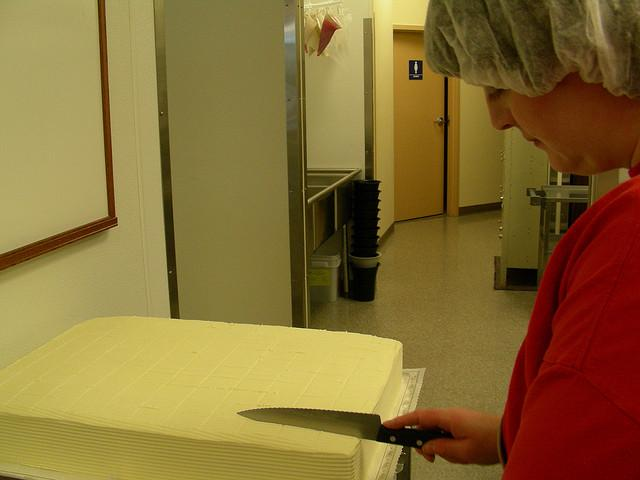

In [ ]:
tokenized_dataset[0]["image"]

In [ ]:
sample = tokenized_dataset[0]  # pick first sample
image = sample["image"]  # PIL.Image
image_tensor = transform(image).unsqueeze(0)  # [1, 3, 448, 448]

# --- 4. Tokenize your custom text prompt ---
context = " ".join(sample["sentences_raw"])
user = "What is the image about?"
template = f"""
answer the question or contune the conversation based on the context which is extracted from an image.
context: {context}
user: {user}
answer:
"""
# labels = tokenizer(context, return_tensors="pt",
#         max_length=128,
#         truncation=True,
#         padding="max_length",)['input_ids']
# labels.to("cuda")
# labels
labels = torch.tensor(sample["labels"]).unsqueeze(0)
labels

tensor([[    2,   250,   693,  2498,    10,  1161,    15,    69,   471,  3931,
            10,  8492,     4,  1437,    83,   693,  3931,    10,   739,  1104,
          5462,  8492,     4,    83,   693,  2498,    10,  2549,  1161,  3931,
            10,   739,  5462,  8492,     4,    89,    16,    10,   693,    14,
            16,  3931,    10,  1104,  8492,    83,   693, 10032,    10,  8492,
            19,     5,   124,     9,    10,  8172,    18,  7023,     4,  1437,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  

In [ ]:
# labels.shape
# labels[labels == 1] = -100
# labels

In [ ]:
" ".join(sample["sentences_raw"])

"A woman wearing a net on her head cutting a cake.  A woman cutting a large white sheet cake. A woman wearing a hair net cutting a large sheet cake. there is a woman that is cutting a white cake A woman marking a cake with the back of a chef's knife. "

In [ ]:
image_tensor = image_tensor.to("cuda")

In [ ]:
# input_ids = inputs["input_ids"].to("cuda")
input_ids = torch.ones((1,128), dtype=torch.long).to("cuda")

In [ ]:
text_embeddings = model.llm.get_input_embeddings()(input_ids)

In [ ]:
# attention_mask = inputs["attention_mask"].to("cuda")
attention_mask = torch.zeros((1,128), dtype=torch.long).to("cuda")

In [ ]:
# labels = input_ids

In [ ]:
image_features = model.vision_encoder.forward_features(image_tensor)

if image_features.ndim == 2:
    image_features = image_features.unsqueeze(1)

projected_image_features = model.projection(image_features)

image_mask = torch.ones(
    projected_image_features.shape[:2],
    dtype=attention_mask.dtype,
    device=attention_mask.device,
)

In [ ]:
projected_image_features.shape, image_mask.shape

(torch.Size([1, 785, 768]), torch.Size([1, 785]))

In [ ]:
input_ids.shape, attention_mask.shape, text_embeddings.shape, labels.shape

(torch.Size([1, 128]),
 torch.Size([1, 128]),
 torch.Size([1, 128, 768]),
 torch.Size([1, 128]))

In [ ]:
output_ids = model.llm.generate(
    inputs_embeds=projected_image_features,
    attention_mask=image_mask,
    max_new_tokens=100, # How many new words to generate
)
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(generated_text)

 knife,,,,,,,,,,,,,,,,,,,.,,,,,, is is is is,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,, is is is,,,,,,,,,,,,,,,,,


In [ ]:
model.to("cuda")
print()

In [ ]:
output_ids = forward(
    model=model, image = image_tensor, input_ids = input_ids, attention_mask = attention_mask, labels=labels
)


image_features torch.Size([1, 785, 768])

projected_image_features torch.Size([1, 785, 768])

text_embeddings torch.Size([1, 128, 768])

combined_embeddings torch.Size([1, 913, 768])

image_mask torch.Size([1, 785])

mask torch.Size([1, 913])

image_labels torch.Size([1, 785])

tensor([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100

In [ ]:
output_ids["loss"]

tensor(7.9536, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
output_ids.shape

torch.Size([1, 100])

In [ ]:
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("\n--- Generated Output ---")
print(generated_text)


--- Generated Output ---
 o-line, and the other two are the only ones I can think of.

I think the only one I can think of is the one that was in the movie "The Last Jedi".

I think the only one I can think of is the one that was in the movie "The Last Jedi".

I think the only one I can think of is the one that was in the movie "The Last Jedi".

I think the only one I can think of


In [ ]:

# --- CORRECTED DECODING STEP ---
# Get the length of the input prompt
# input_length = inputs_embeds.shape[1]

# Slice the output_ids to get ONLY the generated tokens
# newly_generated_ids = output_ids[0, input_length:]

# Decode only the newly generated IDs
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("\n--- Generated Output ---")
print(generated_text)


--- Generated Output ---

I'm fine. I'm just tired. I'm not sure what's going on. I'm not sure what's going on. I'm not sure what's going on. I'm not sure what's going on. I'm not sure


In [ ]:
with torch.no_grad(): # No need to calculate gradients for this test
    outputs = model(
        image=image_tensor,
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels,
    )

# --- 4. Check the Outputs ---
print("\n--- Checking Outputs ---")

# Check if the loss is calculated
assert outputs.loss is not None, "Loss was not calculated."
print(f"Calculated Loss: {outputs.loss.item():.4f}")

# Check the shape of the logits
# Expected shape: (batch_size, combined_seq_length, vocab_size)
expected_seq_len = model.vision_encoder.pos_embed.shape[1] + input_ids.shape[1]
expected_shape = (1, expected_seq_len, model.llm.config.vocab_size)
assert outputs.logits.shape == expected_shape, \
    f"Logits shape is incorrect. Expected {expected_shape}, but got {outputs.logits.shape}"
print(f"Logits shape: {outputs.logits.shape} (Correct)")

print("\n✅ Test Passed Successfully!")


--- Checking Outputs ---
Calculated Loss: 4.3204
Logits shape: torch.Size([1, 913, 50272]) (Correct)

✅ Test Passed Successfully!


In [ ]:
inputs_embeds.shape, attention_mask_for_generation.shape

(torch.Size([1, 913, 768]), torch.Size([1, 913]))

In [ ]:
# --- Performing Generation ---
print("\n--- Performing Generation ---")

# Prepare the combined embeddings and attention mask
with torch.no_grad():
    image_features = model.vision_encoder.forward_features(image_tensor)
    projected_image_features = model.projection(image_features)
    text_embeddings = model.llm.get_input_embeddings()(input_ids)
    inputs_embeds = torch.cat([projected_image_features, text_embeddings], dim=1)

    image_mask = torch.ones(projected_image_features.shape[:2], dtype=attention_mask.dtype, device=attention_mask.device)
    attention_mask_for_generation = torch.cat([image_mask, attention_mask], dim=1)

# Use the generate method to get clean output
output_ids = model.llm.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=attention_mask_for_generation,
    max_new_tokens=100, # How many new words to generate
)




--- Performing Generation ---


In [ ]:
output_ids

tensor([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10]], device='cuda:0')

In [ ]:
# --- CORRECTED DECODING STEP ---
# Get the length of the input prompt
input_length = inputs_embeds.shape[1]

# Slice the output_ids to get ONLY the generated tokens
newly_generated_ids = output_ids[0, input_length:]

# Decode only the newly generated IDs
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("\n--- Generated Output ---")
print(generated_text)

In [ ]:
text_embeddings = model.llm.get_input_embeddings()(torch.zeros((1,128), dtype=torch.long))
text_embeddings

tensor([[[ 0.1150, -0.1438,  0.0555,  ...,  0.2146,  0.0833,  0.0669],
         [ 0.1150, -0.1438,  0.0555,  ...,  0.2146,  0.0833,  0.0669],
         [ 0.1150, -0.1438,  0.0555,  ...,  0.2146,  0.0833,  0.0669],
         ...,
         [ 0.1150, -0.1438,  0.0555,  ...,  0.2146,  0.0833,  0.0669],
         [ 0.1150, -0.1438,  0.0555,  ...,  0.2146,  0.0833,  0.0669],
         [ 0.1150, -0.1438,  0.0555,  ...,  0.2146,  0.0833,  0.0669]]])

In [ ]:

# --- 5. Generate output ---
with torch.no_grad():
    # Get image features
    image_features = model.vision_encoder.forward_features(image_tensor)
    print(image_features.shape)
    if image_features.ndim == 2:
        image_features = image_features.unsqueeze(1)
    projected_image_features = model.projection(image_features)

    # Token embeddings for the prompt
    text_embeddings = model.llm.get_input_embeddings()(inputs["input_ids"])

    # Combine image + text embeddings
    combined_embeddings = torch.cat([projected_image_features, text_embeddings], dim=1)

    # Build attention mask
    image_mask = torch.ones(
        projected_image_features.shape[:2],
        dtype=inputs["attention_mask"].dtype,
        device="cuda"
    )

    attention_mask = torch.cat([image_mask, inputs["attention_mask"]], dim=1)

    # Use `generate` with inputs_embeds
    generated_ids = model.llm(
        inputs_embeds=combined_embeddings,
        attention_mask=attention_mask,
    )

# --- 6. Decode ---
output_text = tokenizer.decode(generated_ids[0], skip_special_tokens=False)
print("Generated:", output_text)

torch.Size([1, 785, 768])


TypeError: argument 'ids': 'list' object cannot be interpreted as an integer

In [ ]:
tokenizer.decode(sample["input_ids"])

'</s>there is a woman that is cutting a white cake<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'